In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import shap
import warnings
shap.initjs()
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定するよ
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:, 4f}'.format)

### 残差を取り出してlightGBMで予測してみる（時系列性は薄そう）

In [2]:
def rmse(y_true, y_pred):

    return np.sqrt(mse(y_true, y_pred))

In [3]:
df = pd.read_csv('train_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)
df_test = pd.read_csv('test_timeseries_features_added.csv').drop(['month','day','hour','day_of_year'], axis=1)


def format_date_time(df):

    df['date_time'] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

    return df


df = format_date_time(df)
df_test = format_date_time(df_test)

In [4]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
target_names = ['CO', 'C6H6', 'NOx']
features = df.columns.to_list()
features.remove('date_time')
features.remove('day_of_week')
features.remove('working_hours')

for i in targets:
    features.remove(i)

In [5]:
def targets_stl(df):

    for i in range(3):

        stl = STL(df[targets[i]].values, period=24, robust=True)
        stl_series = stl.fit()

        df[targets[i]] = stl_series.resid
    
    return df


def features_stl(df):

    for i in tqdm(range(len(features))):

        stl = STL(df[features[i]].values, period=24, robust=True)
        stl_series = stl.fit()
    
        df[features[i]] = stl_series.resid
    
    return df


df_resid = df.copy()

df_resid = targets_stl(df_resid)
df_resid = features_stl(df_resid)
df_test = features_stl(df_test)

100%|██████████| 127/127 [00:19<00:00,  6.40it/s]


##### 残差成分のグラフ

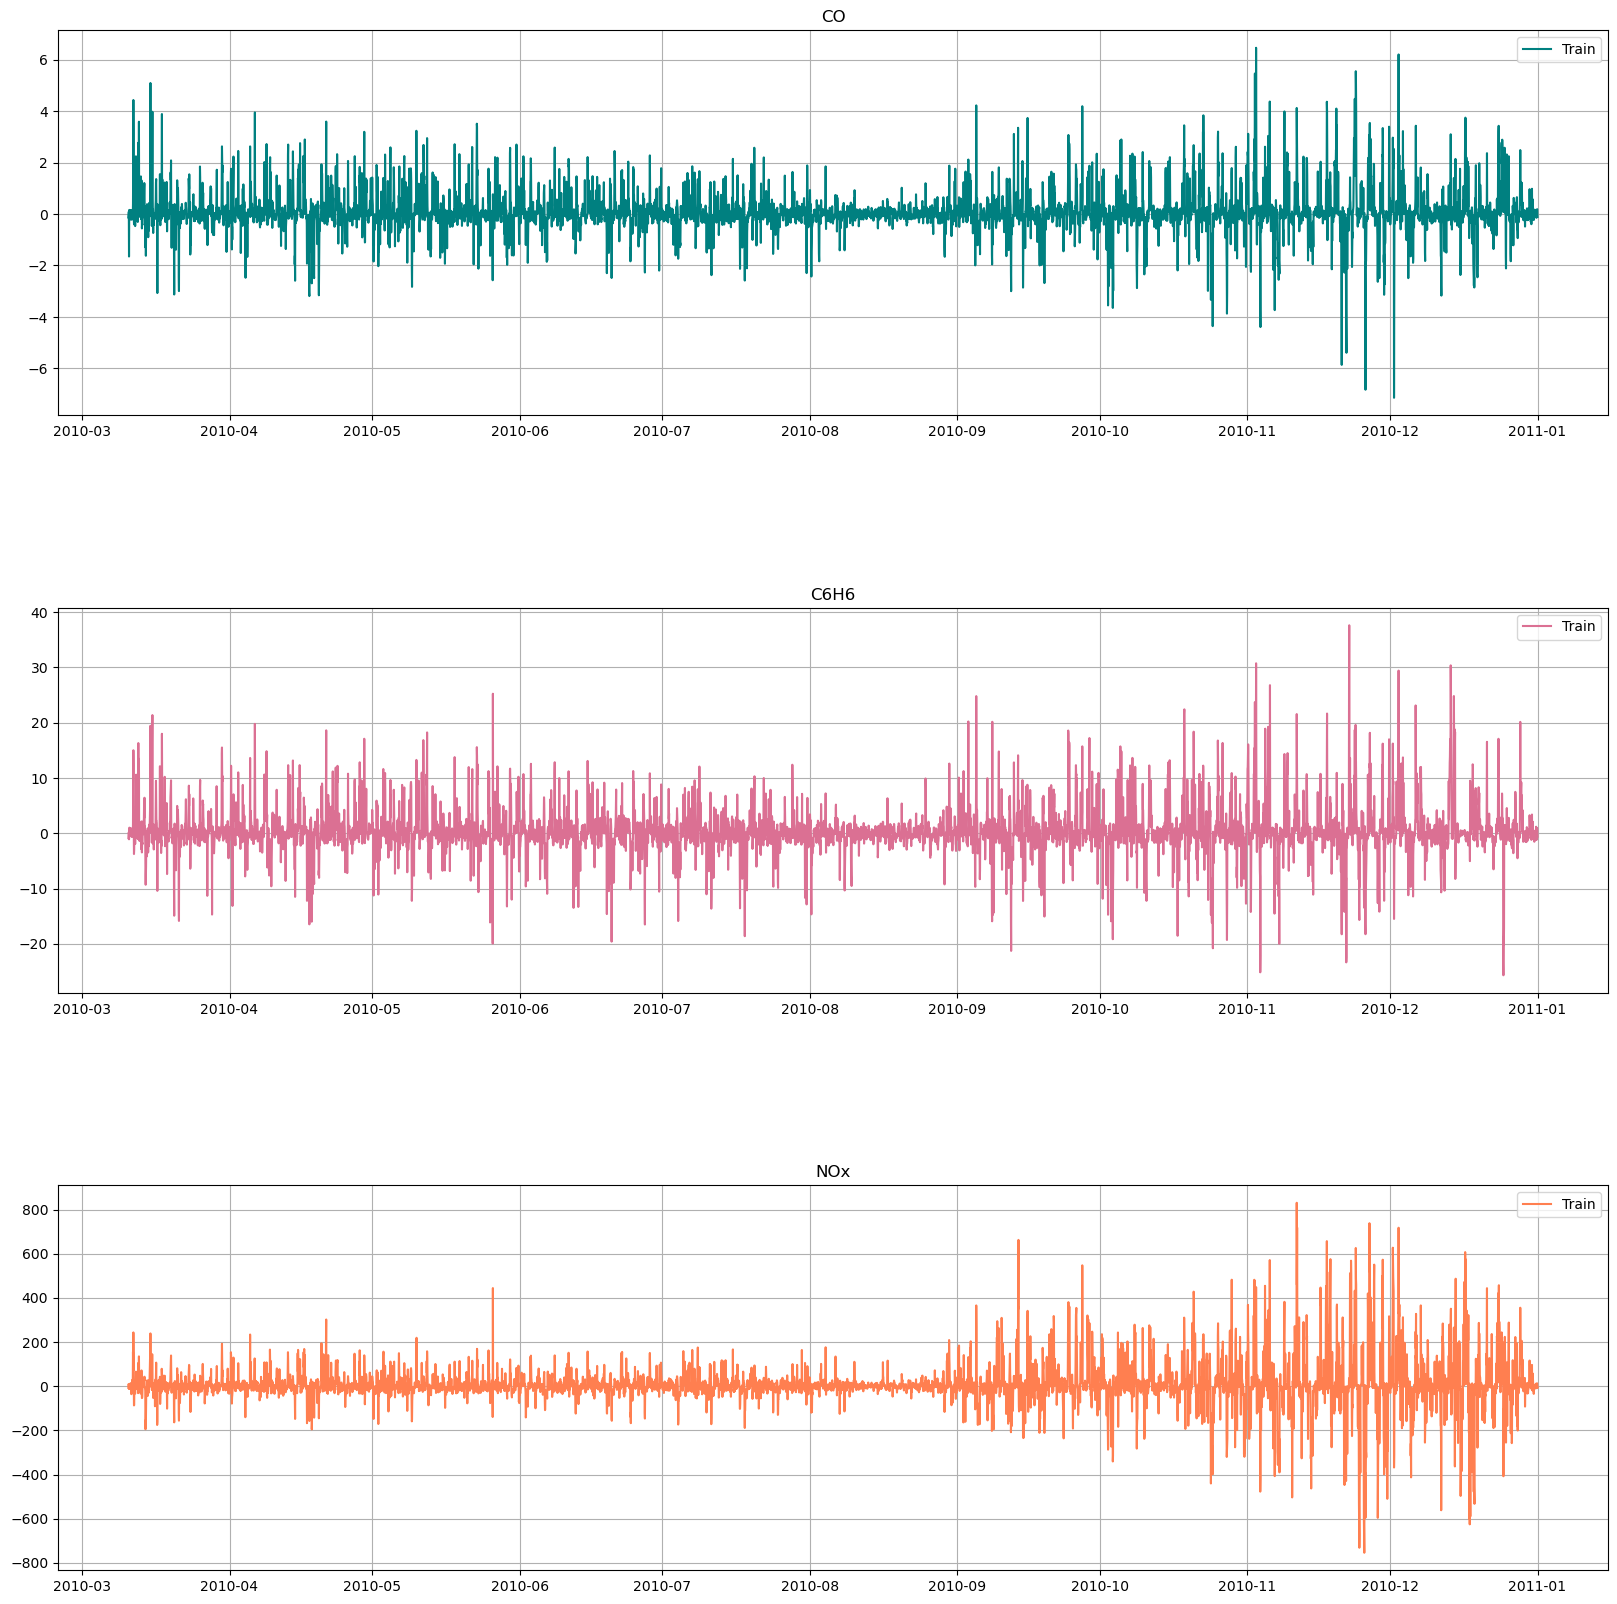

In [6]:
colors = ['teal', 'palevioletred', 'coral']

fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)

for i in range(3):

    axs[i].plot(df_resid['date_time'], df_resid[targets[i]], color=colors[i], label='Train')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

In [7]:
df_resid.set_index('date_time', inplace=True)
df_test.set_index('date_time', inplace=True)

df_resid_CO = df_resid.drop([targets[1], targets[2]], axis=1)
df_resid_C6H6 = df_resid.drop([targets[0], targets[2]], axis=1)
df_resid_NOx = df_resid.drop([targets[0], targets[1]], axis=1)

df_resid_CO = df_resid_CO.rename(columns={targets[0]: 'y'})
df_resid_C6H6 = df_resid_C6H6.rename(columns={targets[1]: 'y'})
df_resid_NOx = df_resid_NOx.rename(columns={targets[2]: 'y'})

df_resid_CO_train, df_resid_CO_val = train_test_split(df_resid_CO, test_size=0.2, shuffle=False)
df_resid_C6H6_train, df_resid_C6H6_val = train_test_split(df_resid_C6H6, test_size=0.2, shuffle=False)
df_resid_NOx_train, df_resid_NOx_val = train_test_split(df_resid_NOx, test_size=0.2, shuffle=False)

In [8]:
categorical_features = ['day_of_week', 'working_hours']

train_y_CO = df_resid_CO_train['y']
train_x_CO = df_resid_CO_train.drop('y', axis=1)
val_y_CO = df_resid_CO_val['y']
val_x_CO = df_resid_CO_val.drop('y', axis=1)

train_y_C6H6 = df_resid_C6H6_train['y']
train_x_C6H6 = df_resid_C6H6_train.drop('y', axis=1)
val_y_C6H6 = df_resid_C6H6_val['y']
val_x_C6H6 = df_resid_C6H6_val.drop('y', axis=1)

train_y_NOx = df_resid_NOx_train['y']
train_x_NOx = df_resid_NOx_train.drop('y', axis=1)
val_y_NOx = df_resid_NOx_val['y']
val_x_NOx = df_resid_NOx_val.drop('y', axis=1)

In [9]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_CO, train_y_CO)
    lgb_valids = lgb.Dataset(val_x_CO, val_y_CO)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_CO = regressor.predict(val_x_CO)

    val_rmse = rmse(val_y_CO, lgb_pred_val_y_CO)
    
    return val_rmse

study_CO = optuna.create_study(direction='minimize')
study_CO.optimize(objective, timeout=300)

In [10]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(train_x_CO, train_y_CO)
valids = lgb.Dataset(val_x_CO, val_y_CO)

model_lgb_CO = lgb.train(study_CO.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_CO = model_lgb_CO.predict(val_x_CO)
rmse_CO = rmse(val_y_CO, val_lgb_CO)

rmse_CO

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 129
[LightGBM] [Info] Start training from score 0.066133


0.7629569738271398

In [11]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
    lgb_valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_C6H6 = regressor.predict(val_x_C6H6)

    val_rmse = rmse(val_y_C6H6, lgb_pred_val_y_C6H6)
    
    return val_rmse

study_C6H6 = optuna.create_study(direction='minimize')
study_C6H6.optimize(objective, timeout=300)

In [12]:
# Oputunaで求めたパラメーターを使い、C6H6の値を予測
trains = lgb.Dataset(train_x_C6H6, train_y_C6H6)
valids = lgb.Dataset(val_x_C6H6, val_y_C6H6)

model_lgb_C6H6 = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_C6H6 = model_lgb_C6H6.predict(val_x_C6H6)
rmse_C6H6 = rmse(val_y_C6H6, val_lgb_C6H6)

rmse_C6H6

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 129
[LightGBM] [Info] Start training from score 0.249863


2.5527078162879446

In [13]:
# OptunaによるlightGBMの最適パラメータ探索
def objective(trial):

    lgb_trains = lgb.Dataset(train_x_NOx, train_y_NOx)
    lgb_valids = lgb.Dataset(val_x_NOx, val_y_NOx)
    
    learning_rate = trial.suggest_float('learning_rate', 0.0, 1.0)
    num_leaves =  trial.suggest_int('num_leaves', 2, 100)
    tree_learner = trial.suggest_categorical('tree_learner', ['serial', 'feature', 'data', 'voting'])
    lambda_l1= trial.suggest_float('lambda_l1', 0.0, 200.0)
    lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 200.0)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    num_iterations = trial.suggest_int('num_iterations', 10, 100)

    lgb_params = {
        'objective': 'regression',
        'boosting_type': 'gbdt', 
        'metrics': 'rmsle', 
        'learning_rate': learning_rate, 
        'num_leaves': num_leaves, 
        'tree_learner': tree_learner,
        'lambda_l1': lambda_l1, 
        'lambda_l2': lambda_l2, 
        'seed': 123, 
        'max_depth': max_depth,
        'num_iterations': num_iterations,
        'verbose': '-1'      
    }

    regressor = lgb.train(params=lgb_params,
                        train_set=lgb_trains,
                        valid_sets=lgb_valids, 
                        categorical_feature=categorical_features
                        )

    lgb_pred_val_y_NOx = regressor.predict(val_x_NOx)

    val_rmse = rmse(val_y_NOx, lgb_pred_val_y_NOx)
    
    return val_rmse

study_NOx = optuna.create_study(direction='minimize')
study_NOx.optimize(objective, timeout=300)

In [14]:
# Oputunaで求めたパラメーターを使い、NOxの値を予測
trains = lgb.Dataset(train_x_NOx, train_y_NOx)
valids = lgb.Dataset(val_x_NOx, val_y_NOx)

model_lgb_NOx = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains, 
                    valid_sets=valids, 
                    categorical_feature=categorical_features
                    )

val_lgb_NOx = model_lgb_NOx.predict(val_x_NOx)
rmse_NOx = rmse(val_y_NOx, val_lgb_NOx)

rmse_NOx

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 5688, number of used features: 129
[LightGBM] [Info] Start training from score 5.407899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


144.47065874257788

##### 結果：

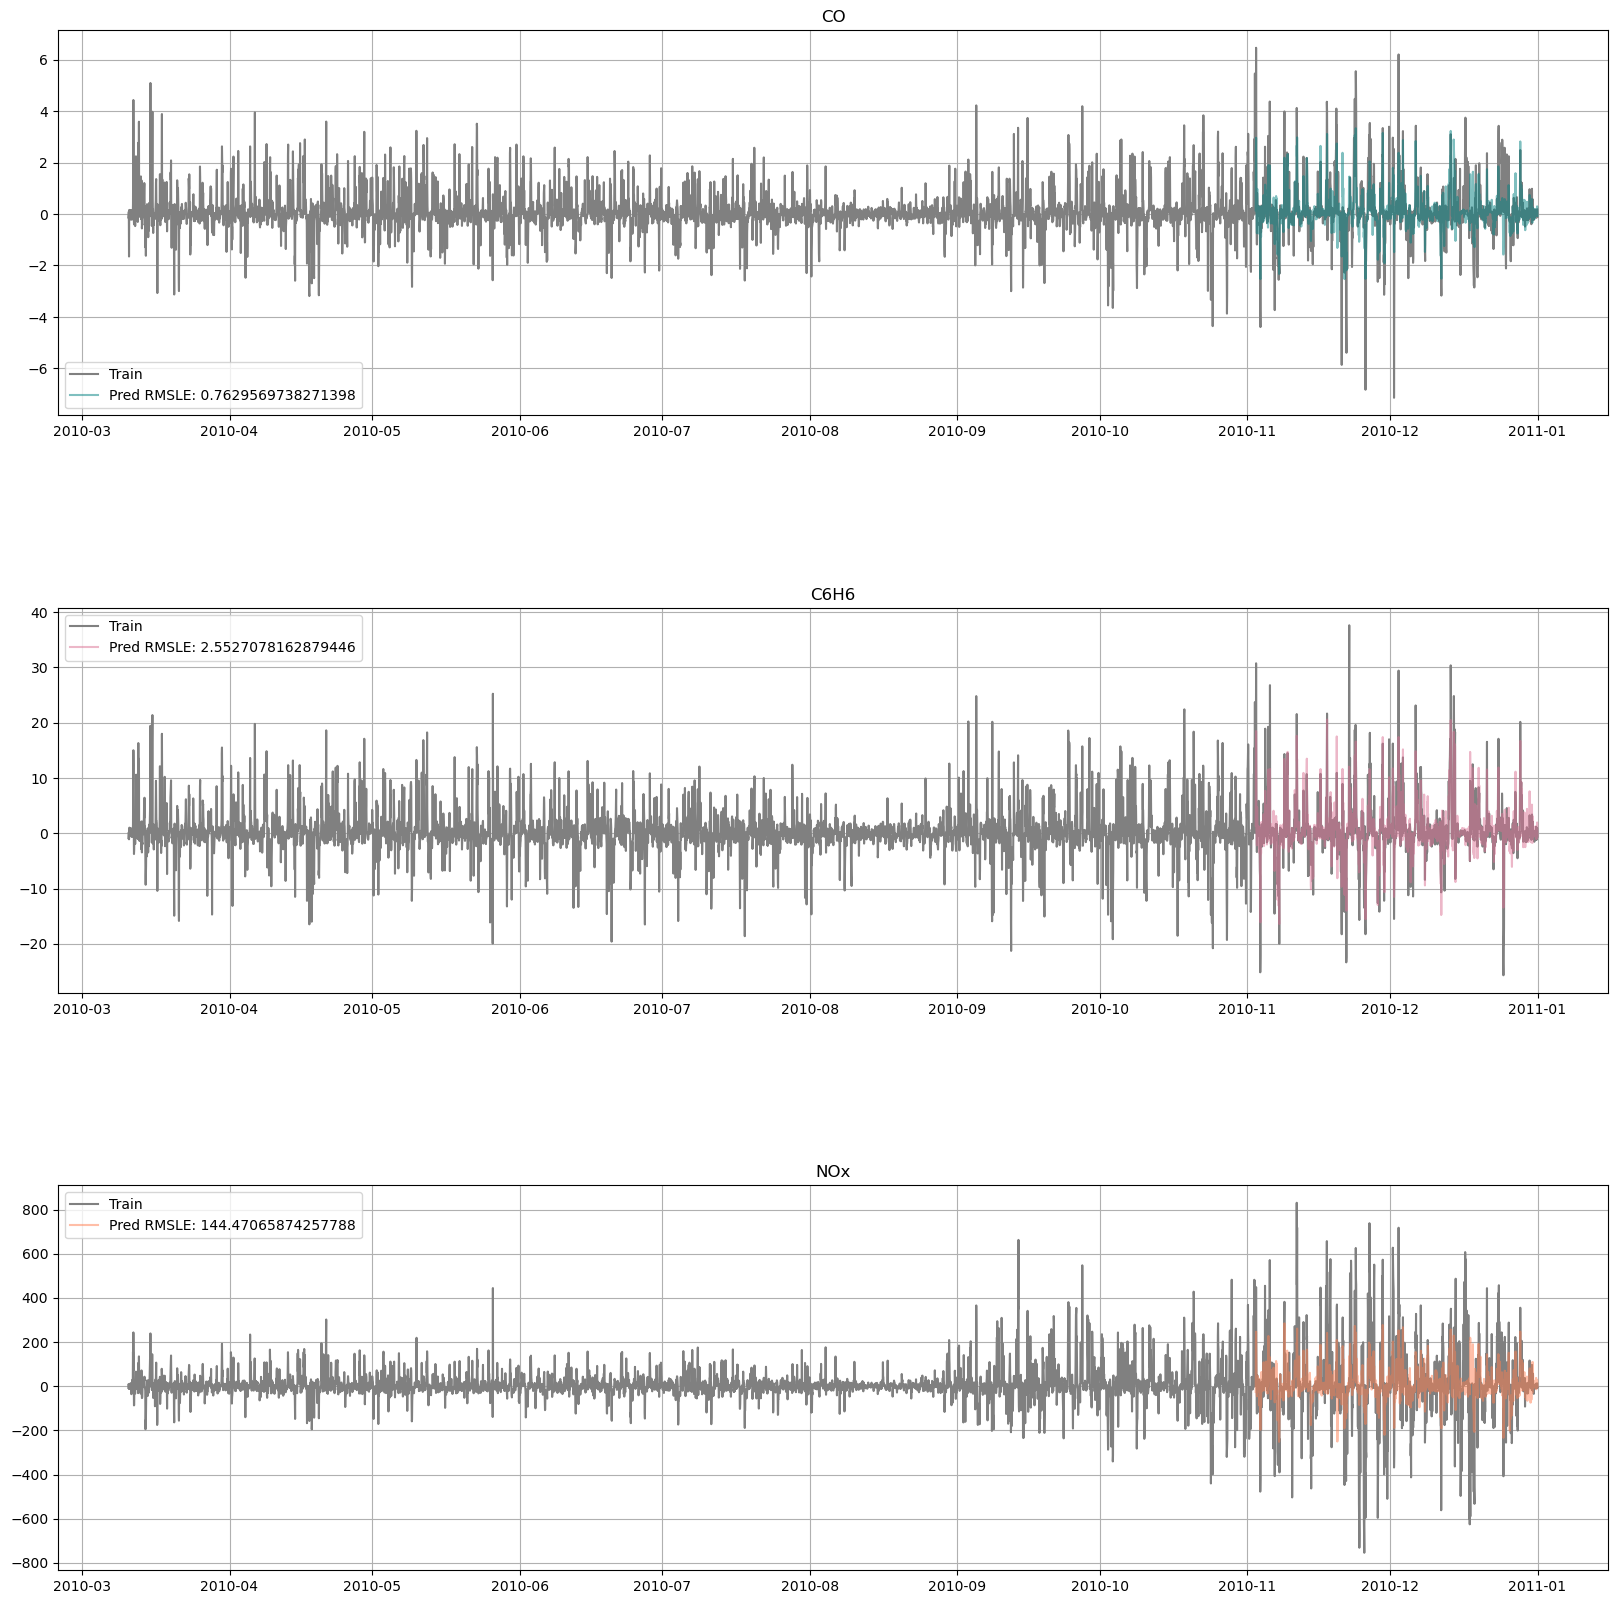

In [15]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name1 = f'val_lgb_{target_names[i]}'
    name2 = f'rmse_{target_names[i]}'  

    axs[i].plot(df_resid.index, df_resid[targets[i]], color='gray', label='Train')
    axs[i].plot(val_x_CO.index, globals()[name1], color=colors[i], alpha=0.5, label=f'Pred RMSLE: {globals()[name2]}')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

##### トレインデータを全部学習させて最終結果を得る

In [16]:
df_resid_CO_y = df_resid_CO['y']
df_resid_CO_x = df_resid_CO.drop(['y'], axis=1)
df_resid_C6H6_y = df_resid_C6H6['y']
df_resid_C6H6_x = df_resid_C6H6.drop(['y'], axis=1)
df_resid_NOx_y = df_resid_NOx['y']
df_resid_NOx_x = df_resid_NOx.drop(['y'], axis=1)

In [17]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_resid_CO_x, df_resid_CO_y)

model_lgb_CO_final = lgb.train(study_CO.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_CO
                    )

pred_CO = model_lgb_CO_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 129


In [18]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_resid_C6H6_x, df_resid_C6H6_y)

model_lgb_C6H6_final = lgb.train(study_C6H6.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_C6H6
                    )

pred_C6H6 = model_lgb_C6H6_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 129


In [19]:
df_resid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7111 entries, 2010-03-10 18:00:00 to 2011-01-01 00:00:00
Columns: 132 entries, deg_C to dew_point_min168
dtypes: float64(130), int64(2)
memory usage: 7.2 MB


In [20]:
# Oputunaで求めたパラメーターを使い、COの値を予測
trains = lgb.Dataset(df_resid_NOx_x, df_resid_NOx_y)

model_lgb_NOx_final = lgb.train(study_NOx.best_trial.params, 
                    train_set=trains,
                    categorical_feature=categorical_features,
                    init_model=model_lgb_NOx
                    )

pred_NOx = model_lgb_NOx_final.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32396
[LightGBM] [Info] Number of data points in the train set: 7111, number of used features: 129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


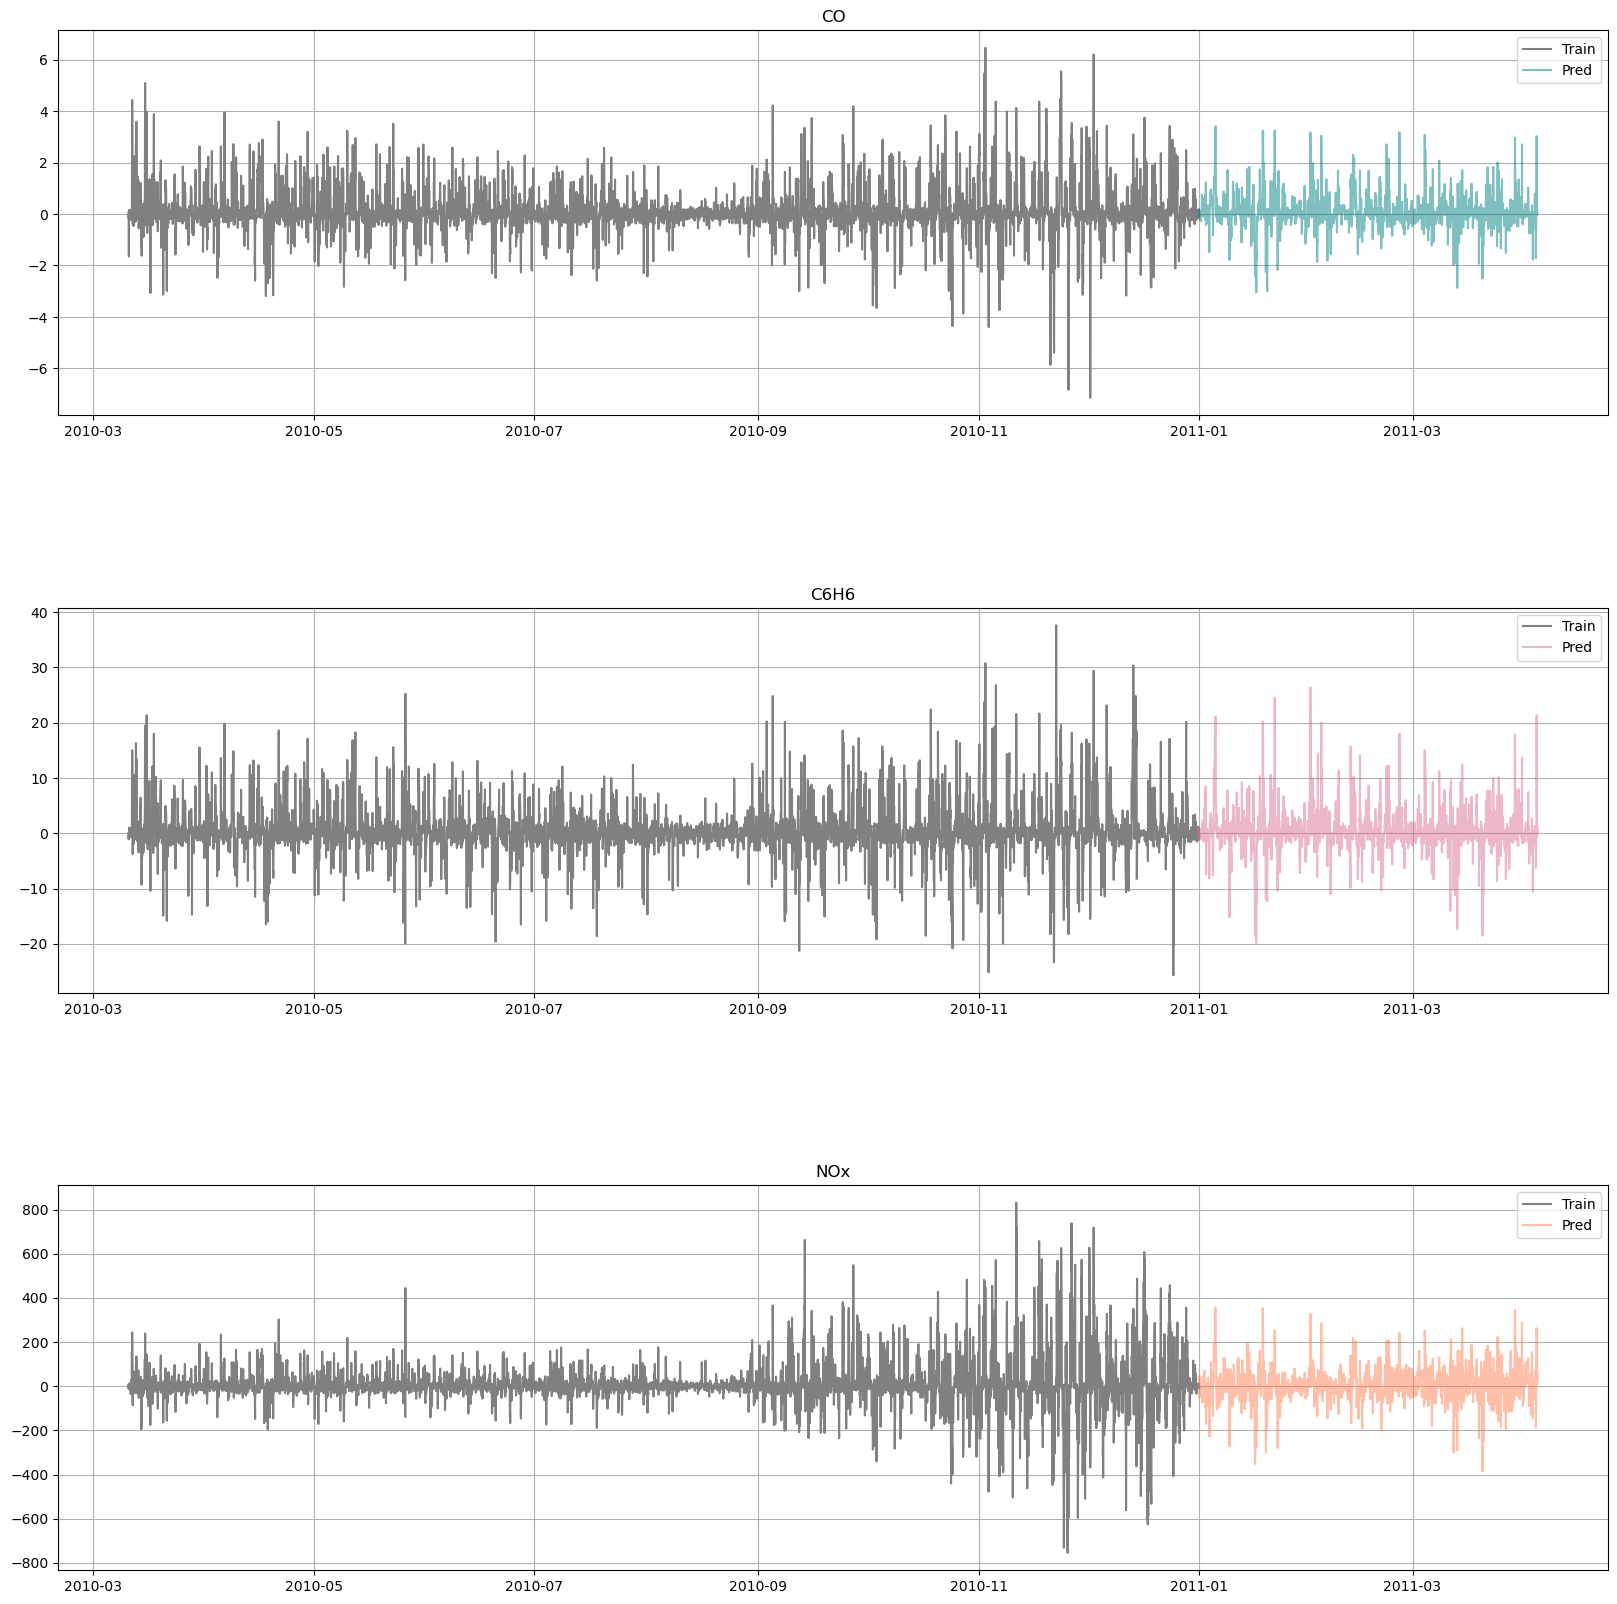

In [21]:
fig, axs = plt.subplots(figsize=(20, 20), ncols=1, nrows=3)
plt.subplots_adjust(hspace = 0.5)


for i in range(3):

    name = f'pred_{target_names[i]}' 

    axs[i].plot(df_resid.index, df_resid[targets[i]], color='gray', label='Train')
    axs[i].plot(df_test.index, globals()[name], color=colors[i], alpha=0.5, label=f'Pred')
    axs[i].set_title(f'{target_names[i]}')
    axs[i].grid(axis='both')
    axs[i].legend()

plt.show()

In [22]:
dt_val = val_x_CO.index
cols_val = ['val_resid_CO', 'val_resid_C6H6', 'val_resid_NOx']

df_resid_val = pd.DataFrame(index=dt_val, columns=cols_val)

df_resid_val['val_resid_CO'] = val_lgb_CO
df_resid_val['val_resid_C6H6'] = val_lgb_C6H6
df_resid_val['val_resid_NOx'] = val_lgb_NOx

In [23]:
df_resid_val.astype('str')

,val_resid_CO,val_resid_C6H6,val_resid_NOx
date_time,,,
2010-11-02 18:00:00,0.1466779352309242,1.369529316297614,-25.977323345474236
2010-11-02 19:00:00,2.384470047749981,12.721300192426183,196.82619514065073
2010-11-02 20:00:00,2.959391232753622,18.472865506907507,246.46443514172302
2010-11-02 21:00:00,1.5981007724344678,9.746112674733348,144.9379977979272
2010-11-02 22:00:00,0.11422257869478467,0.667947042910682,25.926906955013095
...,...,...,...
2010-12-31 20:00:00,-0.05475461920711861,-0.9060440958083059,6.566241597737297
2010-12-31 21:00:00,0.1176075287800937,0.0779348829521639,26.9891841683776
2010-12-31 22:00:00,0.29755142242473576,1.9470611775124795,27.87592593007467


In [26]:
df_resid_val.to_csv('resid_val.csv')

結果出力

In [24]:
dt = df_test.index
cols = ['resid_CO', 'resid_C6H6', 'resid_NOx']

df_resid_pred = pd.DataFrame(index=dt, columns=cols)

df_resid_pred['resid_CO'] = pred_CO
df_resid_pred['resid_C6H6'] = pred_C6H6
df_resid_pred['resid_NOx'] = pred_NOx

In [25]:
df_resid_pred.to_csv('resid.csv', index=True)